In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("xinleili/nuswide")

print("Path to dataset files:", path)

Path to dataset files: /home/mzums/.cache/kagglehub/datasets/xinleili/nuswide/versions/1


In [3]:
from fastai.vision.all import *

In [4]:
torch.cuda.is_available()

True

In [8]:
path = '/home/mzums/.cache/kagglehub/datasets/xinleili/nuswide/versions/1/NUS-WIDE/'

In [10]:
with open(f'{path}/database_img.txt', 'r') as f:
    dataPath = f.read().splitlines()
with open(f'{path}/database_label.txt', 'r') as f:
    dataTag = f.read().splitlines()

In [20]:
df = pd.DataFrame({'path': dataPath,'tags': dataTag})
df

,path,tags
0,images/0001_2124494179.jpg,2
1,images/0002_174174086.jpg,2
2,images/0003_221597162.jpg,2
3,images/0004_540895766.jpg,2
4,images/0005_262041423.jpg,2
...,...,...
193729,images/0595_460543444.jpg,3 4
193730,images/0596_391097803.jpg,4
193731,images/0597_6221368.jpg,4
193732,images/0598_144768190.jpg,4


In [24]:
def get_x(r): 
    return path / r['path']

def get_y(r): 
    return r['tags'].split()

In [25]:
dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_x=get_x,
    get_y=get_y,
    item_tfms=Resize(224),
    splitter=RandomSplitter(valid_pct=0.2)
)

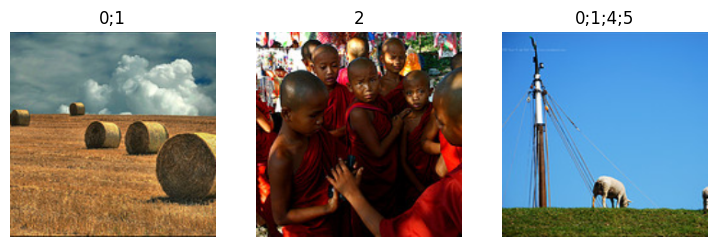

In [26]:
dls = dblock.dataloaders(df)

dls.show_batch(nrows=1, ncols=3)

In [27]:
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=240x160,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
                      0., 0., 0., 0., 0., 0.]))

In [28]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#1) ['2']

In [29]:
dblock.summary(df)

Setting-up type transforms pipelines
0       images/0001_2124494179.jpg    2 
1        images/0002_174174086.jpg    2 
2        images/0003_221597162.jpg    2 
3        images/0004_540895766.jpg    2 
4        images/0005_262041423.jpg    2 
...                            ...   ...
193729   images/0595_460543444.jpg  3 4 
193730   images/0596_391097803.jpg    4 
193731     images/0597_6221368.jpg    4 
193732   images/0598_144768190.jpg    4 
193733  images/0599_1368074986.jpg    4 

[193734 rows x 2 columns]
Found 193734 items
2 datasets of sizes 154988,38746
Setting up Pipeline: get_x -> PILBase.create
Setting up Pipeline: get_y -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} -> OneHotEncode -- {'c': None}

Building one sample
  Pipeline: get_x -> PILBase.create
    starting from
      path    images/0571_2485620373.jpg
tags                            2 
Name: 111365, dtype: object
    applying get_x gives
      /home/mzums/.cache/kagglehub/datasets/xinleili/nusw

In [30]:
learn = vision_learner(dls, resnet18)

In [31]:
x, y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape

torch.Size([64, 21])

In [32]:
activs[0]

TensorImage([-1.7017e+00,  6.7128e-01, -2.8170e-01, -3.8016e+00, -1.7696e+00,
             -1.6425e+00,  2.9990e+00,  4.7136e+00, -1.3353e+00, -1.7501e+00,
             -2.9846e-01,  2.2443e+00, -6.8766e-04, -1.0383e+00, -7.9618e-01,
              5.7554e-01, -4.9907e-01, -9.0214e-01,  5.9480e-01,  1.5573e+00,
             -1.0543e+00], grad_fn=<AliasBackward0>)

In [33]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh) == targ.bool()).float().mean()

In [34]:
learn = vision_learner(dls, resnet50, metrics = partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.142646,0.125096,0.938588,11:38
1,0.132500,0.117959,0.940877,11:28
2,0.126145,0.114617,0.942399,11:33
3,0.122579,0.111279,0.942487,11:34


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.116054,0.108607,0.941349,13:51
1,0.111045,0.105542,0.944261,13:16
2,0.097503,0.105853,0.945329,13:22


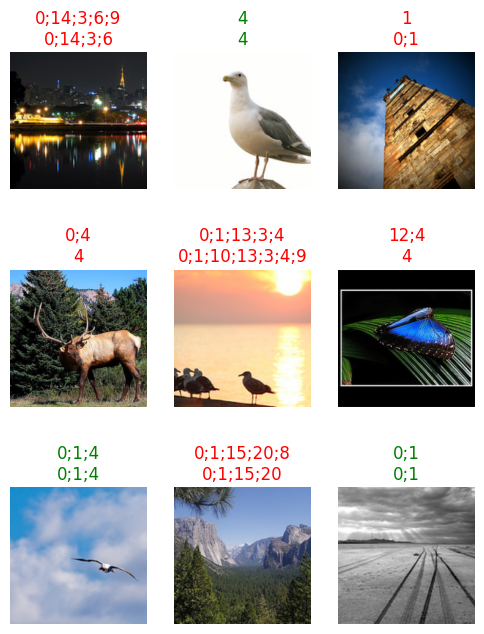

In [43]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))